##아래 코드에서 사용된 알고리즘 흐름
**목표 : Autoencoder 에서 enocder를 통과한 같은 label의 data는 latent space 내에서 서로 가까이에 존재하도록**

논문에 구현된 방식대로 진행을 하다보니 도저히 clustering 이 제대로 이루어지지 않아서 생각을 다시 해봄
본질적으로 두가지 조건이 중요함을 정리해두려 한다
1. latent space 에서 중심이 서로 확연하게 달라야 함 (서로 멀리 떨어져있을 수록 좋음)
2. 같은 label의 data가 encoder를 거쳐서 거의 비슷한 지점에 도착해야 함

위 두가지 조건을 성립하게끔 해보니 그냥 신경망을 제대로 학습 시켜서 loss값이 작아지면 작아질수록 초기 중심을 구할 때 각 중심들이 서로 확연하게 달라짐을 알 수 있었다 (그만큼 특징을 잘 뽑아내는듯)

알고리즘
1. Autoencoder 신경망을 먼저 정해놓은 epoch수만큼 학습시킨다
2. 0-9 label data를 heuristic 하게 뽑고 enocder를 보내서 초기 중심들을 설정한다
3. 모든 훈련 data에 대해서 초기 중심에 대해 할당시킨다

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
transform = transforms.ToTensor() 
# 이미지를 pytorch tensor 로 변환
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
print(len(mnist_data)) # 60000
# tensor들로 변환된 mnist_data를 64크기의 batch로 random하게 뽑기
# shuffle 은 매 epoch마다 data가 shuffle 되도록
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True) # 60000장의 data를 64 장씩 random 으로 뽑아서 총 937개가 있는 data -> data와 label 로 구성되어 있음

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

60000


In [3]:
dataiter = iter(data_loader)
images, labels = dataiter.next() # batch size가 64인 data [64,1,28,28]
print(images.shape) # torch.Size([64, 1, 28, 28])
print(labels.shape) 
# 1개 image의 pixel값이 어떤 범위에 있는지 ,# output 출력할 때 활성화 함수 정하기 위해 필요
print(torch.min(images), torch.max(images)) 

torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(0.) tensor(1.)


In [4]:
# nn.Sequential 짤 때, 콤마(,) 점(.) 으로 찍는 것 조심
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder=nn.Sequential(
        nn.Linear(784, 250),
        nn.ReLU(),
        nn.Linear(250,50),
        nn.ReLU(),
        nn.Linear(50,10)  # (N,10) 
    )

    self.decoder=nn.Sequential(
        nn.Linear(10,50),
        nn.ReLU(),
        nn.Linear(50,250),
        nn.ReLU(),
        nn.Linear(250,784),
        nn.Sigmoid()  # 입력이 0-1 사이 이므로 출력도 0-1 사이가 되도록
    )

  # 복원된 image 구하기
  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded # (encoded, decoded) 나란히 튜플로 나오게끔

  # embedding -> latent vector 구하기
  def encoding(self,x):
    encoded = self.encoder(x)
    return encoded

  # forwarding -> recon 구하기
  def forwarding(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [7]:
# Autoencdoer 모델 생성
model=Autoencoder()
criterion = nn.MSELoss() # Mean Squared Error 가 Loss function이 되도록 함 
# lr 과 weight_decay 를 적절히 변형해가며 최적을 찾아볼 수 있다
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) # parameter를 갱신하는 것을 optimizer라고 함

In [9]:
# Training 과정 -> 15번의 epoch 
num_epochs = 15  # 정확하게 하려면 숫자 늘리면 됨
outputs = []
for epoch in range(num_epochs):
  for (img, _) in data_loader:
    img = img.reshape(-1,28*28)
    recon = model.forwarding(img) # 재구성된 이미지
    loss = criterion(recon,img)  

    optimizer.zero_grad() #gradient 0으로 초기화
    loss.backward() #backwarkd 하면서 gradient 구하는 과정
    optimizer.step() #매개변수 갱신 과정
  
  print(f'Epoch :{epoch+1}, Loss:{loss.item():.4f}')
  outputs.append((epoch,img,recon))

Epoch :1, Loss:0.0292
Epoch :2, Loss:0.0241
Epoch :3, Loss:0.0206
Epoch :4, Loss:0.0213
Epoch :5, Loss:0.0182
Epoch :6, Loss:0.0179
Epoch :7, Loss:0.0245
Epoch :8, Loss:0.0169
Epoch :9, Loss:0.0160
Epoch :10, Loss:0.0170
Epoch :11, Loss:0.0160
Epoch :12, Loss:0.0116
Epoch :13, Loss:0.0159
Epoch :14, Loss:0.0103
Epoch :15, Loss:0.0163


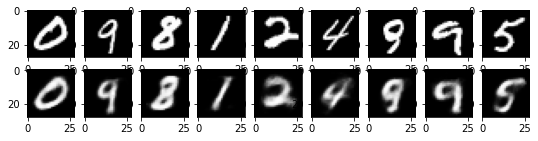

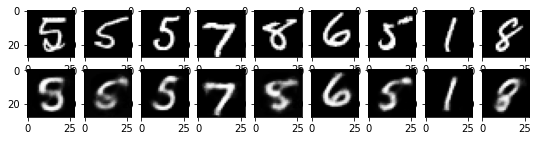

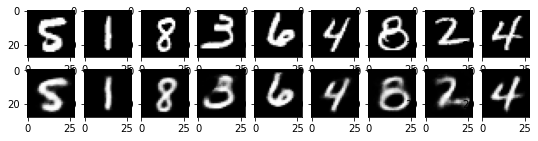

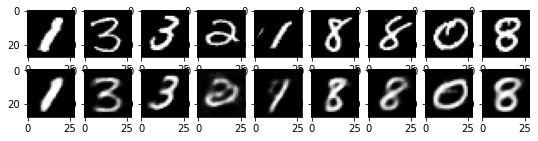

In [10]:
# 실제 재구성된 이미지가 어떠한지 확인
for k in range(0, num_epochs, 4):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs = outputs[k][1].detach().numpy()
  recon = outputs[k][2].detach().numpy()

  # 입력값 출력
  for i, item in enumerate(imgs):
    if i>=9 : break
    plt.subplot(2, 9, i+1)
    item = item.reshape(-1, 28, 28) # 원래 image 크기로 변환
    # item: 1, 28, 28
    plt.imshow(item[0])

  for i, item in enumerate(recon):
    if i >= 9: break
    plt.subplot(2,9,9+i+1) # row_length + i + 1
    item = item.reshape(-1,28,28)
    # item: 1, 28, 28
    plt.imshow(item[0]) # 3차원이라 item[0] 이렇게 읽어야 하는듯

In [11]:
# heuristic 한 방식으로 label 값 찾기 -> mnist_data는 순서가 정해져 있음 
print(mnist_data[1][1]) # 0
print(mnist_data[3][1]) # 1
print(mnist_data[5][1]) # 2
print(mnist_data[7][1]) # 3
print(mnist_data[2][1]) # 4
print(mnist_data[0][1]) # 5
print(mnist_data[13][1]) # 6
print(mnist_data[15][1]) # 7
print(mnist_data[17][1]) # 8
print(mnist_data[4][1]) # 9

0
1
2
3
4
5
6
7
8
9


In [15]:
# heuristic 한 방식으로 초기 중심점 잡기
c_0 = model.encoding(mnist_data[1][0].view(-1,28*28)) #0
c_1 = model.encoding(mnist_data[3][0].view(-1,28*28)) #1
c_2 = model.encoding(mnist_data[5][0].view(-1,28*28)) #2
c_3 = model.encoding(mnist_data[7][0].view(-1,28*28)) #3
c_4 = model.encoding(mnist_data[2][0].view(-1,28*28)) #4
c_5 = model.encoding(mnist_data[0][0].view(-1,28*28)) #5
c_6 = model.encoding(mnist_data[13][0].view(-1,28*28)) #6
c_7 = model.encoding(mnist_data[15][0].view(-1,28*28)) #7
c_8 = model.encoding(mnist_data[17][0].view(-1,28*28)) #8
c_9 = model.encoding(mnist_data[4][0].view(-1,28*28)) #9


In [16]:
# 초기 중심값 선정방법 1 -> 0-9 까지의 label data 를 encoding 시킨 것 
# 초기 중심값 선정방법 2 -> torch.rand() : 0과 1 사이의 숫자를 균등하게 생성 or torch.randn() : 평균이 0이고 표준편차가 1인 가우시안 정규분포를 이용해 생성
init_centroids={}
for i in range(10):
  init_centroids['C{}'.format(i)]=0 # 딕셔너리 key 값 동적생성 
init_centroids['C0']=c_0
init_centroids['C1']=c_1
init_centroids['C2']=c_2
init_centroids['C3']=c_3
init_centroids['C4']=c_4
init_centroids['C5']=c_5
init_centroids['C6']=c_6
init_centroids['C7']=c_7
init_centroids['C8']=c_8
init_centroids['C9']=c_9
print(init_centroids)

{'C0': tensor([[  0.1188,   9.3387, -17.3201,  17.5614,   3.9759, -21.0143,  12.2763,
           8.0657, -16.9431,  -0.1355]], grad_fn=<AddmmBackward0>), 'C1': tensor([[-13.2603,  -9.9706,   9.2424,   2.2353,  11.2155, -21.6751,   3.0737,
           6.4475, -12.3284,  -2.6110]], grad_fn=<AddmmBackward0>), 'C2': tensor([[ -8.9593,  -4.3940,  -6.6477,  15.2125,  11.2769, -25.1266,  14.5639,
           4.0616, -12.2527,  -2.2622]], grad_fn=<AddmmBackward0>), 'C3': tensor([[ -6.4543,   9.6878,   3.6111,  24.4504,   6.4266, -28.8816,  12.8516,
           0.7247, -24.6842,  -6.5044]], grad_fn=<AddmmBackward0>), 'C4': tensor([[-11.3627,   3.7138,  -2.8936,   2.8555,   4.5168,   0.6267,   5.4000,
          -4.9650, -15.7845,   0.5068]], grad_fn=<AddmmBackward0>), 'C5': tensor([[ -9.0587,  12.2806,   3.6494,  13.7069,   0.6349, -31.7637,   8.0696,
           3.8977,  -8.9872,   0.6377]], grad_fn=<AddmmBackward0>), 'C6': tensor([[ -5.2264,  -3.0256, -12.6871,   6.4490,  -1.6675, -26.6510,  14.89

In [17]:
# 가장 가까운 key 값 return 하는 함수
# dictinary에 'C0' , 'C1' ... 이 KEY로 들어가고 value 가 tensor 로 만들고 정렬해서 최소값에 해당하는 key 뽑기
def closest_center(centroids, encoded_x):
  distances={}
  for key in centroids.keys():
    distance=torch.sum((centroids[key] - encoded_x)**2).item()
    distances[key]=distance
  # print(distances) # {'C0': 0.0, 'C1': 0.012900883331894875, 'C2': 0.006580686662346125 .... }
  return sorted(distances.items(), key=lambda x:x[1])[0][0]  # [('C3', 0.0001), ('CO', 0.01), ('C1', 0.2), ... ] 에서 첫 번째 튜플의 첫번 째 원소

# print(closest_center(init_centroids, model.encoding(mnist_data[1][0].view(-1,28*28)))) # 'str' type

In [18]:
#Clustering
# 중심들에 모든 훈련 data를 할당하는 과정
cluster_assignments={}
for i in range(10):
  cluster_assignments['C{}'.format(i)]={} # 딕셔너리 key 값 동적생성 
for key in cluster_assignments.keys():
  for i in range(10):
    cluster_assignments[key][i]=[]

for index,(img,label) in enumerate(mnist_data):
  new_img=img.view(-1,784)
  encoded_data=model.encoding(new_img)
  key = closest_center(init_centroids, encoded_data)
  dictionary = cluster_assignments[key]
  dictionary[label].append(index)

In [19]:
# accuracy 뽑아내는 함수
# 일단은 각 중심에 속한 data 개수 뽑아내는 함수
def print_accuracy_and_distribution(assignments):
  cluster_accuracy={}
  cluster_distribution={}
  index=0
  for key in assignments.keys():
    cluster_accuracy[key]={}
    cluster_distribution[key]={}
    sum=0
    for i in assignments[key].keys():
      sum+=len(assignments[key][i])
      cluster_distribution[key][i]=len(assignments[key][i])
    cluster_accuracy[key]= len(assignments[key][index])/sum
    index+=1
  
  print(cluster_accuracy)
  print("\n")
  print(cluster_distribution)
  print("\n")

In [20]:
print_accuracy_and_distribution(cluster_assignments)

{'C0': 0.8826825127334466, 'C1': 0.8411910669975186, 'C2': 0.7211552558275912, 'C3': 0.5783385909568874, 'C4': 0.3869182389937107, 'C5': 0.5078619193927345, 'C6': 0.853575306344036, 'C7': 0.7776039338399643, 'C8': 0.5595385980479148, 'C9': 0.4028485289531136}


{'C0': {0: 5199, 1: 0, 2: 91, 3: 148, 4: 1, 5: 288, 6: 14, 7: 91, 8: 18, 9: 40}, 'C1': {0: 0, 1: 5763, 2: 106, 3: 58, 4: 208, 5: 118, 6: 41, 7: 360, 8: 105, 9: 92}, 'C2': {0: 242, 1: 35, 2: 4919, 3: 322, 4: 72, 5: 544, 6: 90, 7: 177, 8: 343, 9: 77}, 'C3': {0: 58, 1: 0, 2: 313, 3: 2750, 4: 0, 5: 254, 6: 2, 7: 0, 8: 1329, 9: 49}, 'C4': {0: 145, 1: 50, 2: 135, 3: 191, 4: 1538, 5: 368, 6: 127, 7: 554, 8: 185, 9: 682}, 'C5': {0: 1, 1: 88, 2: 63, 3: 2295, 4: 0, 5: 2810, 6: 5, 7: 5, 8: 200, 9: 66}, 'C6': {0: 225, 1: 2, 2: 92, 3: 24, 4: 198, 5: 219, 6: 5503, 7: 5, 8: 162, 9: 17}, 'C7': {0: 2, 1: 1, 2: 12, 3: 4, 4: 248, 5: 55, 6: 0, 7: 3479, 8: 18, 9: 655}, 'C8': {0: 50, 1: 531, 2: 178, 3: 242, 4: 111, 5: 623, 6: 135, 7: 216, 8: 3153, 9: